#**Text Classification: Amazon Reviews**

This task is to implement a ML solution for a multi-task classification problem from text data (mostly short texts). Specifically, you are provided with Amazon reviews (the text is the review title and the review main body joined together) and your task is to predict the following attributes:

* The number of stars associated with the review (on a scale of 1 to 5).
* Whether a product is from the category “Video Games” (“video_games”) or “Musical Instrument” (“musical_instrument”).

Note that for the first attribute you can choose whether to use multiclass classification or regression. You can choose whether to predict both features simultaneously or separately. Additionally, the dataset is provided with a further attribute: whether the review is verified or not (either True or False), which is optional to use. If you want to explore the data further, a separate dataset with the text field split into the original fields “review title”, “review main body” can be provided upon request.


---



### **Importing and installing the required libraries**

In [66]:
!pip install contractions
!pip install textsearch
!pip install tqdm

#python modules
import string
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import model_selection
import seaborn as sns
import re
import contractions
from bs4 import BeautifulSoup
import tqdm
import unicodedata

#nltk libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

#sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

#Tensorflow layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#fix random seed for reproducibility
seed = 42
np.random.seed(seed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **1.   Exploratory Data Analysis**

### **Importing Amazon Review Dataset**

In [67]:
#Fetching Amazon review dataset and reviewing the data types
df = pd.read_csv('processed_reviews_split_surnamesR_minimal.csv')
df

,review_id,text,verified,review_score,product_category
0,product_review_000000,I am one of those people who had Gran Turismo ...,False,1.0,video_games
1,product_review_000001,This game is awful for several reasons.\n1. T...,False,1.0,video_games
2,product_review_000002,This case is great for travel with the 3Ds or ...,False,5.0,video_games
3,product_review_000003,My go-to mic cable for quite a few years now. ...,True,5.0,musical_instruments
4,product_review_000004,The left one falls fairly frequently even when...,True,4.0,video_games
...,...,...,...,...,...
32912,product_review_032912,"Well, when we look at this game, we are faced ...",False,2.0,video_games
32913,product_review_032913,This is an awesome game. It is a must buy. It ...,False,5.0,video_games
32914,product_review_032914,I had purchased a 3 inch pop filter for my Hei...,True,5.0,musical_instruments
32915,product_review_032915,I couldn't get into this game. I would sugges...,True,2.0,video_games


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32917 entries, 0 to 32916
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32917 non-null  object 
 1   text              32908 non-null  object 
 2   verified          32811 non-null  object 
 3   review_score      32917 non-null  float64
 4   product_category  32011 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [69]:
df.shape

(32917, 5)

In [70]:
#Creating multiple columns to monitior all the null values and duplicated values along with their reason of exclusion

df['excluded'] = df.isna().sum(axis=1).apply(lambda x: 1 if x == 0 else 0)

df['reason_for_exclusion'] = df.isnull().sum(axis=1).apply(lambda x: 'Missing values' if x == 0  else 'N/A')

m1 =  df.duplicated(['text'])   

df['reason_for_exclusion'] = np.select([m1],['duplicated'], default='N/A')

df.insert(len(df.columns)-6, 'excluded', df.pop('excluded'))

df.insert(len(df.columns)-5, 'reason_for_exclusion', df.pop('reason_for_exclusion'))  

In [71]:
df

,review_id,excluded,reason_for_exclusion,text,verified,review_score,product_category
0,product_review_000000,1,N/A,I am one of those people who had Gran Turismo ...,False,1.0,video_games
1,product_review_000001,1,N/A,This game is awful for several reasons.\n1. T...,False,1.0,video_games
2,product_review_000002,1,N/A,This case is great for travel with the 3Ds or ...,False,5.0,video_games
3,product_review_000003,1,N/A,My go-to mic cable for quite a few years now. ...,True,5.0,musical_instruments
4,product_review_000004,1,N/A,The left one falls fairly frequently even when...,True,4.0,video_games
...,...,...,...,...,...,...,...
32912,product_review_032912,1,duplicated,"Well, when we look at this game, we are faced ...",False,2.0,video_games
32913,product_review_032913,1,N/A,This is an awesome game. It is a must buy. It ...,False,5.0,video_games
32914,product_review_032914,1,N/A,I had purchased a 3 inch pop filter for my Hei...,True,5.0,musical_instruments
32915,product_review_032915,1,N/A,I couldn't get into this game. I would sugges...,True,2.0,video_games


In [72]:
df['reason_for_exclusion'].unique()

array(['N/A', 'duplicated'], dtype=object)

In [73]:
#Dowloading the datset with null value and duplicated 
df.to_csv('exclusions_dataset_task4.csv')

In [81]:
#Creating a new dataframe with the data required for classification
dataset = df[['text','review_score','product_category']]

In [82]:
dataset

,text,review_score,product_category
0,I am one of those people who had Gran Turismo ...,1.0,video_games
1,This game is awful for several reasons.\n1. T...,1.0,video_games
2,This case is great for travel with the 3Ds or ...,5.0,video_games
3,My go-to mic cable for quite a few years now. ...,5.0,musical_instruments
4,The left one falls fairly frequently even when...,4.0,video_games
...,...,...,...
32912,"Well, when we look at this game, we are faced ...",2.0,video_games
32913,This is an awesome game. It is a must buy. It ...,5.0,video_games
32914,I had purchased a 3 inch pop filter for my Hei...,5.0,musical_instruments
32915,I couldn't get into this game. I would sugges...,2.0,video_games


## **2.   Data Pre-Processing**

In [83]:
#Checking for Null Values
dataset.isnull().sum()

text                  9
review_score          0
product_category    906
dtype: int64

In [84]:
#Checking for any duplicates in the text columns
dataset.duplicated().sum()

920

In [85]:
#Removing the Duplicates in text column
dataset=dataset.drop_duplicates('text', keep='first')

In [86]:
#Removing Null values in the dataset
dataset.dropna(inplace=True)
dataset.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(29739, 3)

In [87]:
dataset.isnull().sum()

text                0
review_score        0
product_category    0
dtype: int64

In [88]:
dataset['review_score'].value_counts()

 5.0    17629
 4.0     5662
 3.0     2856
 1.0     1711
 2.0     1417
-1.0      464
Name: review_score, dtype: int64

In [89]:
dataset['review_score'] = dataset['review_score'].replace([-1.0],1.0).astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [90]:
dataset['review_score'].unique()

array([1, 5, 4, 3, 2])

## **3.   Data Splitting**

In [91]:
#Build train and test datasets
text = dataset['text'].values
category = dataset['product_category'].values

train_text = text[:20800]
train_category = category[:20800]

test_text = text[20800:]
test_category = category[20800:]

### **3.1   Text Wrangling & Normalisation - Text Processing**

In [92]:
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [93]:
%%time
dataset['cleantext'] = pre_process_corpus(dataset['text'])
dataset.head()

100%|██████████| 29739/29739 [00:08<00:00, 3565.14it/s]

CPU times: user 8.07 s, sys: 317 ms, total: 8.39 s
Wall time: 8.36 s



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
#Build train and test datasets
reviews = dataset['cleantext'].values
category = dataset['product_category'].values

train_reviews = reviews[:4300]
train_category = category[:4300]

test_reviews = reviews[4300:]
test_category = category[4300:]

In [95]:
#After preprocesing
dataset.isnull().sum()

text                0
review_score        0
product_category    0
cleantext           0
dtype: int64

### **3.2   Splitting the dataset into Train and Test Sets**

In [96]:
t = Tokenizer(oov_token='<UNK>')
#fit the tokenizer on the documents
t.fit_on_texts(train_reviews)
t.word_index['<PAD>'] = 0

In [97]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('improvise', 22133), ('<PAD>', 0), 1)

In [98]:
train_sequences = t.texts_to_sequences(train_reviews)

In [99]:
test_sequences = t.texts_to_sequences(test_reviews)

In [100]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=22134
Number of Documents=4300


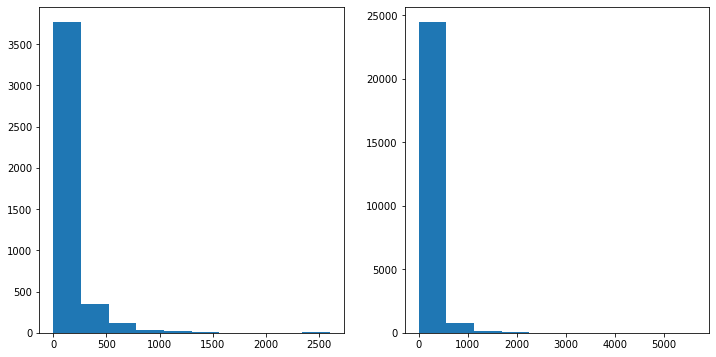

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### **3.3   Sequencing Normalisation**

In [102]:
MAX_SEQUENCE_LENGTH = 1800

In [103]:
#Pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((4300, 1800), (25439, 1800))

### **3.4   Encoding Labels**

In [104]:
le = LabelEncoder()
num_classes=2 # “video_games” -> 1, “musical_instrument” -> 0

In [105]:
y_train = le.fit_transform(train_category)
y_test = le.transform(test_category)

In [106]:
VOCAB_SIZE = len(t.word_index)

## **4.   Preparing the Model**

Since textual data is a sequence of words, we utilize 1D convolutions to scan through the sentences. The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification.

In [107]:
EMBED_SIZE = 300
EPOCHS = 2
BATCH_SIZE = 128

In [108]:
#Creating the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1800, 300)         6640200   
                                                                 
 conv1d_3 (Conv1D)           (None, 1800, 128)         153728    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 900, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 900, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 450, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 450, 32)          

### **4.1   Model Training**

In [109]:
#Fitting the model
model.fit(X_train, y_train, 
          validation_split=0.3,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
24/24 [==============================] - 154s 6s/step - loss: 0.5882 - accuracy: 0.6767 - val_loss: 0.4590 - val_accuracy: 0.6915
Epoch 2/2
24/24 [==============================] - 152s 6s/step - loss: 0.3143 - accuracy: 0.8412 - val_loss: 0.2585 - val_accuracy: 0.8822


### **4.2   Model Evaluation**

In [110]:
#Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

795/795 [==============================] - 309s 388ms/step - loss: 0.2775 - accuracy: 0.8834
Accuracy: 88.34%


In [111]:
predictions = (model.predict(X_test) > 0.5).astype("int32").ravel()
predictions[:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

In [113]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['musical_instrument', 'video_games']
print(classification_report(y_test, predictions))
#Confusion matrix
cm = confusion_matrix(y_test, predictions)
pd.DataFrame(confusion_matrix(y_test, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      8342
           1       0.97      0.86      0.91     17097

    accuracy                           0.88     25439
   macro avg       0.86      0.90      0.87     25439
weighted avg       0.90      0.88      0.89     25439



,musical_instrument,video_games
musical_instrument,7844,498
video_games,2467,14630


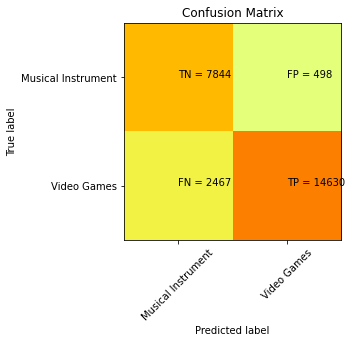

In [114]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#plt.figure(figsize = (10,7))
#sn.heatmap(cm, annot=True);
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Musical Instrument','Video Games']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [115]:
#Validation
df_test= pd.DataFrame(df.sample(n=5), columns=['text','product_category'])
df_test

,text,product_category
27263,I just finished the game the other day and abs...,video_games
24800,I had to clean the cartridge before playing it...,video_games
25048,A very good game but no where near as good as ...,video_games
22395,Titanfall doesn't play on my particular Xbox 3...,video_games
30699,One of the most complete transportation tycoon...,NaN


In [117]:
df_test_1_reviews = pre_process_corpus(df_test['text']) #preprocess the data
t.fit_on_texts(df_test_1_reviews)
df_test_1_train_sequences = t.texts_to_sequences(df_test_1_reviews)
df_test_1_X_train = sequence.pad_sequences(df_test_1_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
df_test_1 = (model.predict(df_test_1_X_train) > 0.5).astype("int32").ravel()
df_test_1_pred = ['musical_instruments' if item == 1 else 'video_games' for item in df_test_1]

100%|██████████| 5/5 [00:00<00:00, 1721.80it/s]


In [118]:
df_test['predicted_category'] = df_test_1_pred
df_test

,text,product_category,predicted_category
27263,I just finished the game the other day and abs...,video_games,musical_instruments
24800,I had to clean the cartridge before playing it...,video_games,musical_instruments
25048,A very good game but no where near as good as ...,video_games,musical_instruments
22395,Titanfall doesn't play on my particular Xbox 3...,video_games,musical_instruments
30699,One of the most complete transportation tycoon...,NaN,musical_instruments


## **5.   Multiclassification of text using Tfid Vectorisation**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


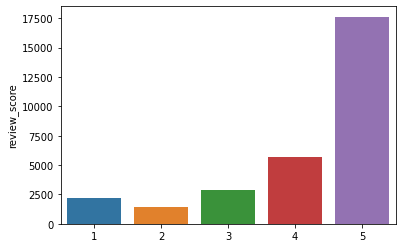

In [119]:
#Checking the target distribution
import seaborn as sns
x=dataset['review_score'].value_counts()
sns.barplot(x.index,x)

In [120]:
#Assign stopwords 
stopwords_list = nltk.corpus.stopwords.words('english')
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [121]:
#Preprocess clean text
stop = stopwords.words('english')
stop.append('I')
stop_words = []
dataset['cleantext'] = dataset['cleantext'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
dataset.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,text,review_score,product_category,cleantext
0,I am one of those people who had Gran Turismo ...,1,video_games,one people gran turismo 1 2 3 4 special additi...
1,This game is awful for several reasons.\n1. T...,1,video_games,game awful several reasons 1 controls awful 2 ...
2,This case is great for travel with the 3Ds or ...,5,video_games,case great travel 3ds ds lite holds 12 games e...
3,My go-to mic cable for quite a few years now. ...,5,musical_instruments,goto mic cable quite years spiral shield easy ...
4,The left one falls fairly frequently even when...,4,video_games,left one falls fairly frequently even gameplay...


In [122]:
#Lemmatisation
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
lemmatizer = WordNetLemmatizer() 

#Lemmatise string 
def lemmatize_word(text): 
    word_tokens = word_tokenize(text) 
    # provide context i.e. part-of-speech 
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens] 
    
    return lemmas 

lemmatized_words = dataset.apply(lambda row: lemmatize_word(row['cleantext']),axis=1) 
#text = 'Fun if you havent played any of the games before!. Fun!'
lemmatized_words

0        [one, people, gran, turismo, 1, 2, 3, 4, speci...
1        [game, awful, several, reason, 1, control, awf...
2        [case, great, travel, 3ds, ds, lite, hold, 12,...
3        [goto, mic, cable, quite, years, spiral, shiel...
4        [leave, one, fall, fairly, frequently, even, g...
                               ...                        
32911    [play, every, single, game, mario, series, wou...
32913    [awesome, game, must, buy, bloody, look, creat...
32914    [purchase, 3, inch, pop, filter, heil, pr, 40,...
32915    [could, get, game, would, suggest, save, money...
32916    [love, elixir, say, reasonable, love, love, wo...
Length: 29739, dtype: object

In [123]:
#Tokenisation
tokenized_words = dataset.apply(lambda row: word_tokenize(row['cleantext']),axis=1)
tokenized_words

0        [one, people, gran, turismo, 1, 2, 3, 4, speci...
1        [game, awful, several, reasons, 1, controls, a...
2        [case, great, travel, 3ds, ds, lite, holds, 12...
3        [goto, mic, cable, quite, years, spiral, shiel...
4        [left, one, falls, fairly, frequently, even, g...
                               ...                        
32911    [played, every, single, game, mario, series, w...
32913    [awesome, game, must, buy, bloody, looks, crea...
32914    [purchased, 3, inch, pop, filter, heil, pr, 40...
32915    [could, get, game, would, suggest, save, money...
32916    [love, elixir, said, reasonable, love, love, w...
Length: 29739, dtype: object

### **5.1   Spliting the data into Train and Test Sets**

In [124]:
#Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features = 30000, ngram_range = (1,3), analyzer = 'char')
X = vectorizer.fit_transform(dataset['cleantext'])
y = dataset['review_score']

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20817, 22899), (8922, 22899), (20817,), (8922,))

## **6.   Implementing numerous Models to Predict Accuracy**

### **6.1   Support Vector Machines**

In [125]:
#Linear SVC
lsv = LinearSVC()
lsv.fit(X_train,y_train)

from sklearn.metrics import classification_report
lsv_predict = lsv.predict(X_test)
lsv_predict

array([5, 4, 5, ..., 5, 4, 5])

In [126]:
#Evaluation

print(classification_report(y_test,lsv_predict))
print(metrics.accuracy_score(y_test,lsv_predict))
print(confusion_matrix(y_test,lsv_predict))

              precision    recall  f1-score   support

           1       0.54      0.34      0.41       656
           2       0.27      0.06      0.10       431
           3       0.39      0.15      0.21       880
           4       0.34      0.20      0.25      1693
           5       0.69      0.93      0.79      5262

    accuracy                           0.63      8922
   macro avg       0.44      0.33      0.35      8922
weighted avg       0.56      0.63      0.57      8922

0.6262048867966824
[[ 220   32   48   44  312]
 [  70   25   47   93  196]
 [  47   19  128  229  457]
 [  26    8   59  335 1265]
 [  43    9   49  282 4879]]


### **6.2   Logistic Regression**

In [127]:
#LRclassification
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_predict = lr.predict(X_test)
lr_predict

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


array([5, 4, 5, ..., 5, 4, 5])

In [128]:
#Evaluation
print(classification_report(y_test,lr_predict))
print(metrics.accuracy_score(y_test,lr_predict))
print(confusion_matrix(y_test,lr_predict))

              precision    recall  f1-score   support

           1       0.61      0.24      0.34       656
           2       0.25      0.01      0.02       431
           3       0.35      0.08      0.14       880
           4       0.37      0.15      0.21      1693
           5       0.65      0.96      0.78      5262

    accuracy                           0.62      8922
   macro avg       0.45      0.29      0.30      8922
weighted avg       0.55      0.62      0.54      8922

0.6214974221026676
[[ 155    8   37   30  426]
 [  41    4   39   59  288]
 [  26    2   74  177  601]
 [  11    0   34  246 1402]
 [  22    2   25  147 5066]]


### **6.3   Naive Bayes**

In [129]:
#Naive Bayes
nbm = MultinomialNB()
nbm.fit(X_train,y_train)
nbm_predict = nbm.predict(X_test)
nbm_predict

array([5, 5, 5, ..., 5, 5, 5])

In [130]:
#Evaluation

print(classification_report(y_test,nbm_predict))
print(metrics.accuracy_score(y_test,nbm_predict))
print(confusion_matrix(y_test,nbm_predict))

              precision    recall  f1-score   support

           1       0.33      0.00      0.00       656
           2       0.00      0.00      0.00       431
           3       0.67      0.00      0.00       880
           4       0.14      0.00      0.00      1693
           5       0.59      1.00      0.74      5262

    accuracy                           0.59      8922
   macro avg       0.35      0.20      0.15      8922
weighted avg       0.47      0.59      0.44      8922

0.5895539116789957
[[   1    0    0    1  654]
 [   1    0    0    1  429]
 [   0    0    2    0  878]
 [   0    0    0    1 1692]
 [   1    0    1    4 5256]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **6.4   Random Forest**

In [131]:
rfr = RandomForestClassifier()
rfr.fit(X_train,y_train)
rfr_predict = rfr.predict(X_test)
rfr_predict

array([5, 5, 5, ..., 5, 5, 5])

In [132]:
#Evaluation

print(classification_report(y_test,rfr_predict))
print(metrics.accuracy_score(y_test,rfr_predict))
print(confusion_matrix(y_test,rfr_predict))

              precision    recall  f1-score   support

           1       0.36      0.01      0.01       656
           2       0.33      0.00      0.00       431
           3       0.30      0.00      0.01       880
           4       0.38      0.02      0.04      1693
           5       0.59      0.99      0.74      5262

    accuracy                           0.59      8922
   macro avg       0.39      0.21      0.16      8922
weighted avg       0.50      0.59      0.45      8922

0.5912351490697153
[[   5    0    1    6  644]
 [   2    1    1   12  415]
 [   1    0    3   16  860]
 [   3    0    3   38 1649]
 [   3    2    2   27 5228]]


## **7.   Best Model**

In [133]:
svm_acc = accuracy_score(y_test,lsv_predict)
log_acc = accuracy_score(y_test,lr_predict)
nb_acc = accuracy_score(y_test,nbm_predict)
rf_acc = accuracy_score(y_test,rfr_predict)

In [134]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest'],
                      'Score': [log_acc, svm_acc, nb_acc, rf_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,SVM,0.626205
0,Logistic Regression,0.621497
3,Random Forest,0.591235
2,Naive Bayes,0.589554
